# Collecting Data from Visible and Thermal Cameras from Plants

In [1]:
import sys
sys.path.append('../')

In [2]:
import time
import threading
from tqdm import tqdm

import cv2
import numpy as np
import ipywidgets as wd
from IPython import display
import matplotlib.pyplot as plt
%matplotlib widget

from skimage.transform import resize
from skimage.exposure import rescale_intensity, equalize_adapthist, equalize_hist

import dlipower
from thorlabs_elliptec import ELLx
from cameras.ids_ueye import uEye
from cameras.lucid_swir import LucidSWIR
from cameras.boson_grabber import BosonFrameGrabber
from analog_discovery.analog_discovery_main import AnalogDiscoveryDevice

import ctypes
import numpy as np
import time
from picosdk.usbtc08 import usbtc08 as tc08
from picosdk.functions import assert_pico2000_ok


## Initialize Hardware

In [3]:
USE_SWITCH = False
SWITCH_IR_LAMP = 1
SWITCH_24VDC = 2
SWITCH_USB_HUB = 6
SWITCH_SLIDER = 8

USE_THERMOCOUPLE = False
THERMOCOUPLE_CHANNELS = [1, 2, 3, 4]

USE_STAGE = True
STAGE_POS_680nm = 0
STAGE_POS_1450nm = 31
STAGE_POS_SP700 = 62
STAGE_POS_LP700 = 93


### Setup Thermocouple

In [4]:
if USE_THERMOCOUPLE:
    # Create chandle and status ready for use
    chandle = ctypes.c_int16()
    status = {}

    # open unit
    status["open_unit"] = tc08.usb_tc08_open_unit()
    assert_pico2000_ok(status["open_unit"])
    chandle = status["open_unit"]

    # set mains rejection to 50 Hz
    status["set_mains"] = tc08.usb_tc08_set_mains(chandle,0)
    assert_pico2000_ok(status["set_mains"])

    for channel in THERMOCOUPLE_CHANNELS:
        # set up channel
        # therocouples types and int8 equivalent
        # B=66 , E=69 , J=74 , K=75 , N=78 , R=82 , S=83 , T=84 , ' '=32 , X=88 
        typeT = ctypes.c_int8(84)
        status["set_channel"] = tc08.usb_tc08_set_channel(chandle, channel, typeT)
        assert_pico2000_ok(status["set_channel"])

    # get minimum sampling interval in ms
    status["get_minimum_interval_ms"] = tc08.usb_tc08_get_minimum_interval_ms(chandle)
    assert_pico2000_ok(status["get_minimum_interval_ms"])

In [5]:
if USE_SWITCH:
    switch = dlipower.PowerSwitch(hostname="192.168.0.100", userid="admin", password="4321")
    switch.off(SWITCH_IR_LAMP)
    switch.on(SWITCH_24VDC)
    switch.on(SWITCH_USB_HUB)
    switch.on(SWITCH_SLIDER)
    print(switch)

In [6]:
vis_cam_type = 'Lucid'        # 'IDS' or 'Lucid'
if vis_cam_type == 'IDS':
    vis_cam_obj = uEye()
    vis_cam_obj.set_exposure(200)
elif vis_cam_type == 'Lucid':
    vis_cam_obj = LucidSWIR()
    vis_cam_obj.printTemperatureInfo()
    vis_cam_obj.set_fps(10)
    vis_cam_obj.set_exposure(20000)
    vis_cam_obj.set_gain(0)
else:
    raise ValueError('Invalid visible camera type')

Found 1 devices from Lucid, connecting to the first device.
Disabled auto exposure.
Current exposure time is 20002.472, min exposure time is 20.544, max exposure time is 99811.616
Disabled auto gain
Current gain value is 0.0, min gain value is 0.0, max gain value is 42.0
Sensor temperature is: 40.0C
TEC temperature is: 15.125C
TECControlTemperatureSetPoint = 15.0
TECCurrent = 0.42065
TECPower = 3.4675
TECStatus = Stable
TECVoltage = 8.246
Set acquisition frame rate to 10.0
Set exposure time to 20002.472
Set gain value to 0.0


In [7]:
thr_cam_id = 0              # 0 or 1

if thr_cam_id == 0:
    thr_cam_obj = BosonFrameGrabber(serial_port="/dev/ttyACM0", device_id=0)
    thr_cam_obj.start_grabber()
    thr_cam_obj.camera.do_ffc()
elif thr_cam_id == 1:
    thr_cam_obj = BosonFrameGrabber(serial_port="/dev/ttyACM1", device_id=2)
    thr_cam_obj.start_grabber()
    thr_cam_obj.camera.do_ffc()

In [8]:
ad = AnalogDiscoveryDevice()

ad.set_dc_voltage(0.6)
ad.set_dc_voltage(0)

In [9]:
if USE_STAGE:
    curr_stage_pos = STAGE_POS_LP700
    stage = ELLx("/dev/ttyUSB1")
    stage.move_absolute_raw(curr_stage_pos, True)

In [10]:
def create_preview_frame(frame_raw: np.ndarray, in_range='image'):
    frame = rescale_intensity(frame_raw.astype(float), in_range=in_range, out_range=(0, 1.0))
    frame = frame * 255
    # frame = equalize_adapthist(frame, clip_limit=0.01) * 255
    # frame = equalize_hist(frame) * 255
    frame = frame.astype(np.uint8)
    frame = cv2.applyColorMap(frame, cv2.COLORMAP_TURBO)[..., ::-1]
    return frame

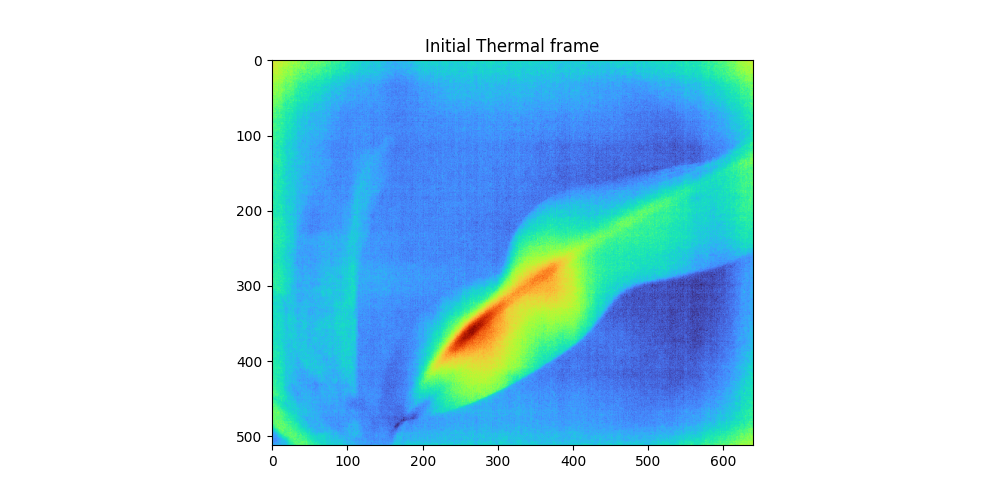

In [11]:
thr_cam_obj.camera.do_ffc()

num_init = 100
init_frame = np.zeros((512, 640), dtype=np.float32)
for _ in range(num_init):
    frame_init, _ = thr_cam_obj.get_latest_frame()
    frame_init = frame_init[:, ::-1]
    init_frame += frame_init
init_frame /= num_init

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(create_preview_frame(init_frame))
ax.set_title('Initial Thermal frame')
plt.show()

KeyboardInterrupt: 

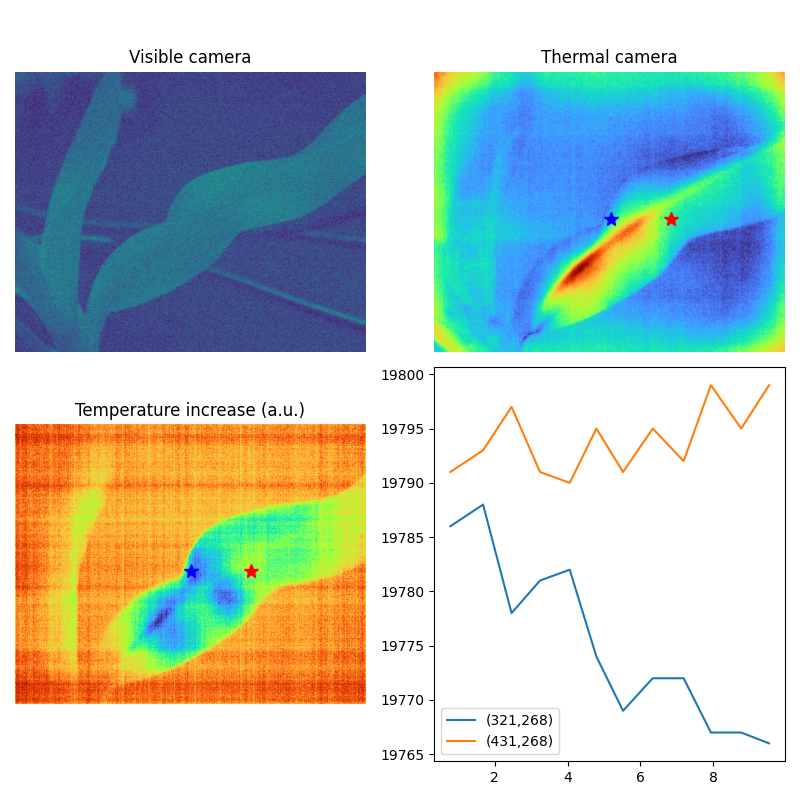

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# vis_cam_obj.configure_gain_per_channel(0, 0, 0, 0)
# thr_cam_obj.camera.do_ffc()
vis_cam_obj.set_fps(60)
if vis_cam_type == 'Lucid':
    vis_cam_obj.set_exposure(20000)
elif vis_cam_type == 'IDS':
    vis_cam_obj.set_exposure(10)

pixel_val1 = []
pixel_val2 = []
tstamp = []
py1, px1 = 268, 321
py2, px2 = 268, 431

start_time = time.time()

while True:
    tic = time.time()

    vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
    thr_img, thr_tstamp = thr_cam_obj.get_latest_frame()

    if vis_cam_type == 'IDS':
        # vis_img_color = np.floor(cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR) / 16).astype(np.uint8)[..., ::-1]
        vis_img_color = cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR)
        vis_img_red = vis_img_color[:, :, 0]
        vis_img_red = (vis_img_red - vis_img_red.min()) / (vis_img_red.max() - vis_img_red.min())
        vis_img_blue = vis_img_color[:, :, 2]
        vis_img_blue = (vis_img_blue - vis_img_blue.min()) / (vis_img_blue.max() - vis_img_blue.min())

    thr_img = thr_img[:, ::-1]
    thr_img_viz = thr_img #- init_frame
    diff_img_viz = thr_img - init_frame
    # thr_img_viz = thr_img[:, :350]
    pixel_val1.append(thr_img_viz[py1, px1])
    pixel_val2.append(thr_img_viz[py2, px2])
    tstamp.append(thr_tstamp - start_time)

    min_val, max_val = np.percentile(thr_img_viz, [0.01, 99.99])
    thr_img_viz = rescale_intensity(thr_img_viz, in_range=(min_val, max_val), out_range=(0, 1.0))*255
    thr_img_viz = thr_img_viz.astype(np.uint8)

    min_val, max_val = np.percentile(diff_img_viz, [0.01, 99.99])
    diff_img_viz = rescale_intensity(diff_img_viz, in_range=(min_val, max_val), out_range=(0, 1.0))*255
    diff_img_viz = diff_img_viz.astype(np.uint8)

    if vis_cam_type == 'Lucid':
        axes[0, 0].clear()
        axes[0, 0].imshow(vis_img)
        axes[0, 0].axis('off')
        axes[0, 0].set_title('Visible camera')
        # axes[0].scatter(px1, py1, c='b', s=10)
        # axes[0].scatter(px2, py2, c='r', s=10)
    elif vis_cam_type == 'IDS':
        axes[0].clear()
        axes[0].imshow(vis_img_red)
        axes[0].set_title('Visible camera RED channel')
        axes[1].clear()
        axes[1].imshow(vis_img_blue)
        axes[1].set_title('Visible camera BLUE channel')
    axes[0, 1].clear()
    axes[0, 1].imshow(thr_img_viz, cmap='turbo')
    axes[0, 1].plot(px1, py1, 'b*', markersize=10)
    axes[0, 1].plot(px2, py2, 'r*', markersize=10)
    axes[0, 1].set_title('Thermal camera')
    axes[0, 1].axis('off')
    axes[1, 0].clear()
    axes[1, 0].imshow(diff_img_viz, cmap='turbo')
    axes[1, 0].plot(px1, py1, 'b*', markersize=10)
    axes[1, 0].plot(px2, py2, 'r*', markersize=10)
    axes[1, 0].set_title('Temperature increase (a.u.)')
    axes[1, 0].axis('off')
    axes[1, 1].clear()
    axes[1, 1].plot(tstamp, pixel_val1, label="({},{})".format(px1, py1))
    axes[1, 1].plot(tstamp, pixel_val2, label="({},{})".format(px2, py2))
    axes[1, 1].legend()
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())


In [15]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax2_twin = ax[2].twinx()

# vis_cam_obj.set_fps(5)
# curr_exp = vis_cam_obj.set_exposure(20)
# vis_cam_obj.configure_gain_per_channel(0, 100, 0, 0)

# plt.ion()

# mean_blue_vals = []
# mean_red_vals = []

# while True:
#     vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
#     # thr_img, thr_tstamp = thr_cam_obj.get_latest_frame()

#     vis_img_color = cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR)[..., ::-1]
#     vis_img_red = vis_img_color[:, :, 0]
#     # vis_img_red = (vis_img_red - vis_img_red.min()) / (vis_img_red.max() - vis_img_red.min())
#     vis_img_blue = vis_img_color[:, :, 2]
#     # vis_img_blue = (vis_img_blue - vis_img_blue.min()) / (vis_img_blue.max() - vis_img_blue.min())

#     mean_blue_vals.append(vis_img_blue.mean())
#     mean_red_vals.append(vis_img_red.mean())

#     ax[0].clear()
#     ax[0].imshow(vis_img_red)
#     ax[0].set_title('Visible camera RED channel, mean: {:.2f}'.format(vis_img_red.mean()))
#     ax[1].clear()
#     ax[1].imshow(vis_img_blue)
#     ax[1].set_title('Visible camera BLUE channel, mean: {:.2f}'.format(vis_img_blue.mean()))
#     ax[2].clear()
#     ax[2].plot(mean_blue_vals, label='Blue channel', color='tab:blue')
#     ax2_twin.clear()
#     ax2_twin.plot(mean_red_vals, label='Red channel', color='tab:red')
#     display.clear_output(wait=True)
#     display.display(plt.gcf())

    

In [16]:
# vis_cam_obj.set_exposure(3000)
# ad.set_dc_voltage(5)
# stage.move_absolute_raw(STAGE_POS_SP700, True)
# for _ in range(10):
#     vis_img_sp700_5 = vis_cam_obj.getNextImage()
# stage.move_absolute_raw(STAGE_POS_LP700, True)
# for _ in range(10):
#     vis_img_lp700_5 = vis_cam_obj.getNextImage()
# ad.set_dc_voltage(2.5)
# stage.move_absolute_raw(STAGE_POS_SP700, True)
# for _ in range(10):
#     vis_img_sp700_2_5 = vis_cam_obj.getNextImage()
# stage.move_absolute_raw(STAGE_POS_LP700, True)
# for _ in range(10):
#     vis_img_lp700_2_5 = vis_cam_obj.getNextImage()
# ad.set_dc_voltage(0)

In [13]:
# fig, ax = plt.subplots(3, 2, figsize=(15, 10))
# ax[0, 0].imshow(vis_img_sp700_5)
# ax[0, 0].set_title(f'SP700, min: {vis_img_sp700_5.min()}, max: {vis_img_sp700_5.max()}')
# ax[0, 1].imshow(vis_img_lp700_5)
# ax[0, 1].set_title(f'LP700, min: {vis_img_lp700_5.min()}, max: {vis_img_lp700_5.max()}')
# ax[1, 0].imshow(vis_img_sp700_2_5)
# ax[1, 0].set_title(f'SP700_2_5, min: {vis_img_sp700_2_5.min()}, max: {vis_img_sp700_2_5.max()}')
# ax[1, 1].imshow(vis_img_lp700_2_5)
# ax[1, 1].set_title(f'LP700_2_5, min: {vis_img_lp700_2_5.min()}, max: {vis_img_lp700_2_5.max()}')
# ax[2, 0].imshow(vis_img_sp700_2_5 / vis_img_sp700_5, vmin=0.4, vmax=1.0)
# ax[2, 0].set_title('SP700_2_5 / SP700')
# ax[2, 1].imshow(vis_img_lp700_2_5 / vis_img_lp700_5, vmin=0.4, vmax=1.0)
# ax[2, 1].set_title('LP700_2_5 / LP700')
# plt.show()


In [14]:
ad.set_dc_voltage(0.0)  

## Collect Acclimation data

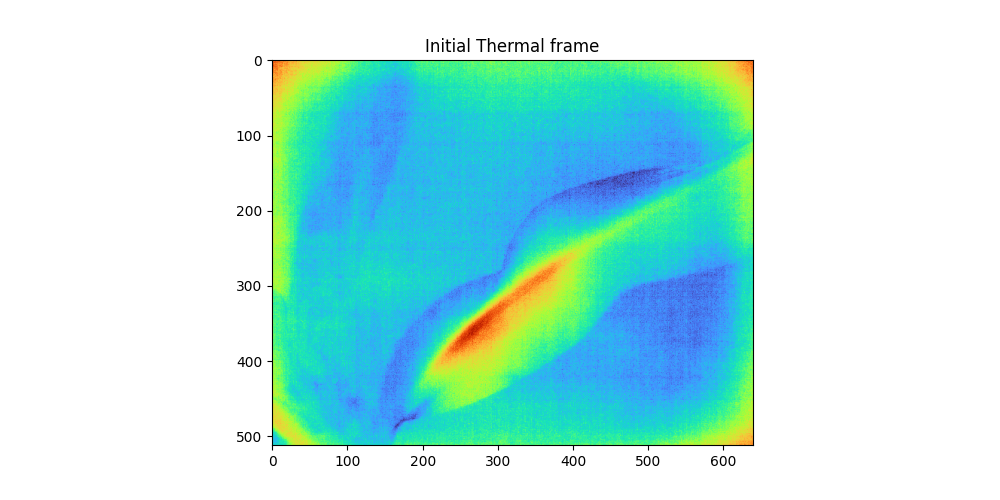

In [15]:
thr_cam_obj.camera.do_ffc()

num_init = 100
init_frame = np.zeros((512, 640), dtype=np.float32)
for _ in range(num_init):
    frame_init, _ = thr_cam_obj.get_latest_frame()
    frame_init = frame_init[:, ::-1]
    init_frame += frame_init
init_frame /= num_init

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(create_preview_frame(init_frame))
ax.set_title('Initial Thermal frame')
plt.show()

In [16]:
eta_0 = 2.5
eta_1 = 5.0
eta_2 = 0.0
# vis_cam_gains = (0, 100, 100, 0)
# vis_cam_obj.configure_gain_per_channel(*vis_cam_gains)
vis_cam_obj.set_fps(10)
# curr_exp = vis_cam_obj.set_exposure(0.5)
curr_exp = vis_cam_obj.set_exposure(10000)
curr_stage_pos = STAGE_POS_LP700
stage.move_absolute_raw(curr_stage_pos, True)

Set acquisition frame rate to 10.0
Set exposure time to 10004.92


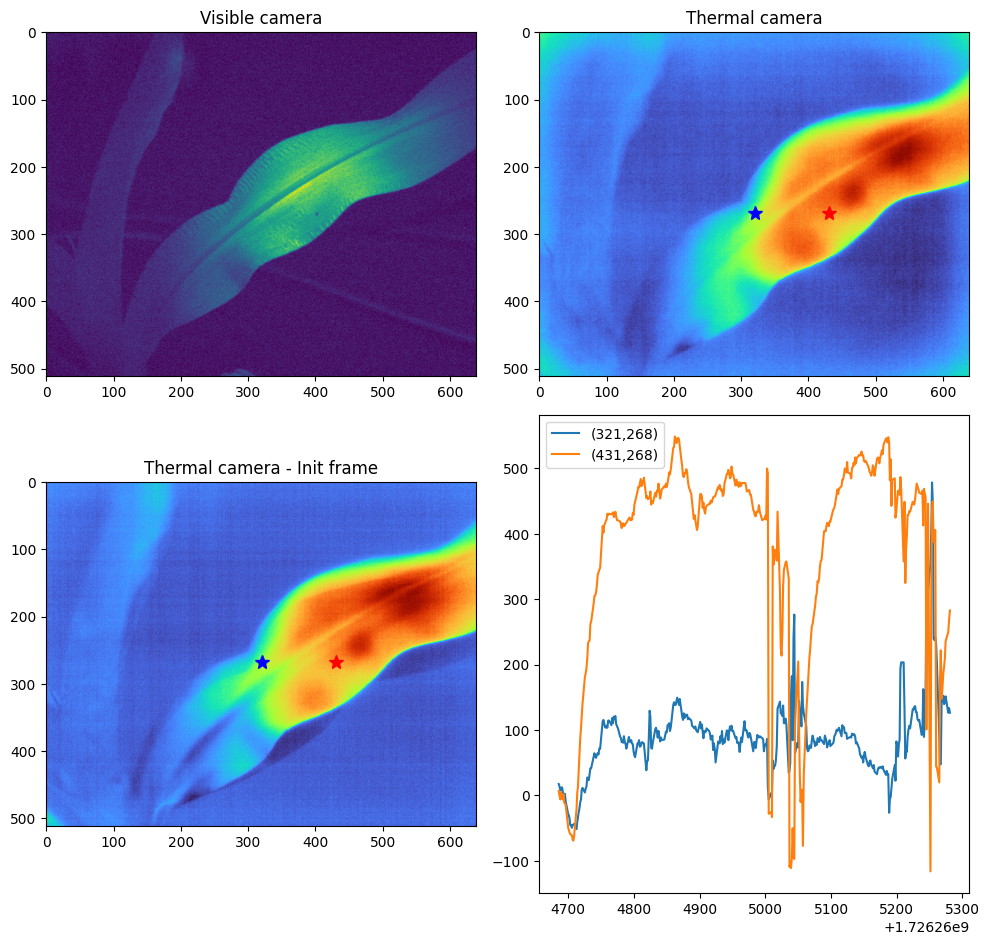

KeyboardInterrupt: 

IndexError: list index out of range

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

IndexError: list index out of range

In [17]:
acc_vis_frames = []
acc_vis_tstamps = []
acc_vis_exposures = []
acc_vis_filter = []
acc_thr_frames = []
acc_thr_tstamps = []
acc_thermocouple_vals = {channel: [] for channel in THERMOCOUPLE_CHANNELS}
acc_thermocouple_tstamps = {channel: [] for channel in THERMOCOUPLE_CHANNELS}

pixel_val1 = []
pixel_val2 = []
tstamp = []
# py1, px1 = 295, 338
# py2, px2 = 195, 338

# py1, px1 = 224, 200
# py2, px2 = 224, 300

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

start_time = time.time()
light_initialized = False

if USE_THERMOCOUPLE:
    # set tc-08 running
    status["run"] = tc08.usb_tc08_run(chandle, status["get_minimum_interval_ms"])
    assert_pico2000_ok(status["run"])

last_frame_tstamp = time.time()
while True:
    vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
    thr_img, thr_tstamp = thr_cam_obj.get_latest_frame()

    if time.time() - last_frame_tstamp > 10:
        if not light_initialized and time.time() - start_time > 20:
            print("Initializing the light")
            # Initialize the light
            ad.set_dc_voltage(eta_0)
            light_initialized = True

        print("Logging a frame")
        acc_vis_frames.append(vis_img)
        acc_vis_tstamps.append(vis_tstamp)
        acc_vis_exposures.append(curr_exp)
        acc_vis_filter.append(curr_stage_pos)
        acc_thr_frames.append(thr_img)
        acc_thr_tstamps.append(thr_tstamp)

        # Capture a SP700 image
        curr_stage_pos = STAGE_POS_SP700
        stage.move_absolute_raw(curr_stage_pos, True)
        curr_exp = vis_cam_obj.set_exposure(3000)
        vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        acc_vis_frames.append(vis_img)
        acc_vis_tstamps.append(vis_tstamp)
        acc_vis_exposures.append(curr_exp)
        acc_vis_filter.append(curr_stage_pos)

        # Return to LP700
        curr_stage_pos = STAGE_POS_LP700
        stage.move_absolute_raw(curr_stage_pos, True)
        curr_exp = vis_cam_obj.set_exposure(10000)

        # Read the thermocouple values
        if USE_THERMOCOUPLE:
            for channel in THERMOCOUPLE_CHANNELS:
                temp_buffer = (ctypes.c_float * 100)()
                times_ms_buffer = (ctypes.c_int32 * 100)()
                overflow = ctypes.c_int16()
                status["get_temp"] = tc08.usb_tc08_get_temp(chandle, ctypes.byref(temp_buffer), ctypes.byref(times_ms_buffer), 100, ctypes.byref(overflow), channel, 0, 1)
                assert_pico2000_ok(status["get_temp"])
                temp_buffer = np.array(temp_buffer)
                times_ms_buffer = np.array(times_ms_buffer)
                valid_indices = np.where(times_ms_buffer != 0.0)
                temp_buffer = temp_buffer[valid_indices]
                times_ms_buffer = times_ms_buffer[valid_indices]
                acc_thermocouple_vals[channel].append(temp_buffer)
                acc_thermocouple_tstamps[channel].append(times_ms_buffer)
            
        last_frame_tstamp = time.time()
        thr_cam_obj.camera.do_ffc()
    
    # # Display the images
    # vis_img_color = cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR)[..., ::-1]

    # vis_img_red = vis_img_color[:, :, 0]
    # vis_img_red = (vis_img_red - vis_img_red.min()) / (vis_img_red.max() - vis_img_red.min())
    # vis_img_green = vis_img_color[:, :, 1]
    # vis_img_green = (vis_img_green - vis_img_green.min()) / (vis_img_green.max() - vis_img_green.min())
    # vis_img_blue = vis_img_color[:, :, 2]
    # vis_img_blue = (vis_img_blue - vis_img_blue.min()) / (vis_img_blue.max() - vis_img_blue.min())

    thr_img = thr_img[:, ::-1]

    diff_img = thr_img - init_frame

    pixel_val1.append(diff_img[py1, px1])
    pixel_val2.append(diff_img[py2, px2])
    tstamp.append(thr_tstamp)

    ax[0, 0].clear()
    ax[0, 0].imshow(vis_img)
    ax[0, 0].set_title('Visible camera')
    # ax[0, 1].clear()
    # ax[0, 1].imshow(vis_img_green)
    # ax[0, 1].set_title('Visible camera GREEN channel')
    # ax[0, 2].clear()
    # ax[0, 2].imshow(vis_img_blue)
    # ax[0, 2].set_title('Visible camera BLUE channel')
    ax[0, 1].clear()
    ax[0, 1].imshow(thr_img, cmap='turbo')
    ax[0, 1].plot(px1, py1, 'b*', markersize=10)
    ax[0, 1].plot(px2, py2, 'r*', markersize=10)
    ax[0, 1].set_title('Thermal camera')
    ax[1, 0].clear()
    ax[1, 0].imshow(diff_img, cmap='turbo')
    ax[1, 0].plot(px1, py1, 'b*', markersize=10)
    ax[1, 0].plot(px2, py2, 'r*', markersize=10)
    ax[1, 0].set_title('Thermal camera - Init frame')
    ax[1, 1].clear()
    ax[1, 1].plot(tstamp, pixel_val1, label="({},{})".format(px1, py1))
    ax[1, 1].plot(tstamp, pixel_val2, label="({},{})".format(px2, py2))
    ax[1, 1].legend()
    plt.tight_layout()
    # plt.draw()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    # if plt.waitforbuttonpress(0.1):
        # break


In [18]:
if USE_THERMOCOUPLE:
    # stop unit
    status["stop"] = tc08.usb_tc08_stop(chandle)
    assert_pico2000_ok(status["stop"])

In [19]:
acc_vis_frames = np.array(acc_vis_frames)
acc_vis_tstamps = np.array(acc_vis_tstamps)
acc_vis_exposures = np.array(acc_vis_exposures)
acc_thr_frames = np.array(acc_thr_frames)
acc_thr_tstamps = np.array(acc_thr_tstamps)

output_filename = '../data/acclimation_data_iowa_{}.npz'.format(time.strftime("%Y%m%d-%H%M%S"))
np.savez(output_filename, acc_vis_frames=acc_vis_frames, acc_vis_tstamps=acc_vis_tstamps, acc_vis_exposures=acc_vis_exposures, acc_thr_frames=acc_thr_frames, acc_thr_tstamps=acc_thr_tstamps, acc_init_thr_frame=init_frame, acc_pixel_val1=pixel_val1, acc_pixel_val2=pixel_val2, pixel_coords=((px1, py1), (px2, py2)), acc_thermocouple_vals=acc_thermocouple_vals, acc_thermocouple_tstamps=acc_thermocouple_tstamps)

In [20]:
# thr_cam_obj.camera.do_ffc()

# vis_cam_obj.configure_gain_per_channel(*vis_cam_gains)
# vis_cam_obj.set_fps(10)
# curr_exp = vis_cam_obj.set_exposure(5)

running = True

## Set up capture thread for visible camera
ls_vis_frames = []
ls_vis_tstamps = []
ls_vis_exposures = []

def visible_capture_thread():
    global ls_vis_frames
    global ls_vis_tstamps
    global ls_vis_exposures
    global running
    
    # exposure_choices = [5 / 1.25**i for i in range(20)]
    while running:
        # set a new exposure
        # target_exposure_val = exposure_choices[len(ls_vis_exposures) % len(exposure_choices)]
        # actual_exposure_val = vis_cam_obj.set_exposure(target_exposure_val, print_message=False)

        vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        ls_vis_frames.append(vis_img)
        ls_vis_tstamps.append(vis_tstamp)
        # ls_vis_exposures.append(actual_exposure_val)
        ls_vis_exposures.append(curr_exp)

vis_cap_thread = threading.Thread(target=visible_capture_thread)

# Set up capture thread for thermal camera
ls_thr_frames = []
ls_thr_tstamps = []

def thermal_capture_thread():
    global ls_thr_frames
    global ls_thr_tstamps
    global running
    while running:
        thr_img, thr_tstamp = thr_cam_obj.get_latest_frame()
        ls_thr_frames.append(thr_img)
        ls_thr_tstamps.append(thr_tstamp)

thr_cap_thread = threading.Thread(target=thermal_capture_thread)

# Set up capture thread for thermocouple
ls_thermocouple_vals = {channel: [] for channel in THERMOCOUPLE_CHANNELS}
ls_thermocouple_tstamps = {channel: [] for channel in THERMOCOUPLE_CHANNELS}

def thermocouple_capture_thread():
    global ls_thermocouple_vals
    global ls_thermocouple_tstamps
    global running
    global THERMOCOUPLE_CHANNELS
    last_collection_time_thermocouple = time.time()
    while running:
        if time.time() - last_collection_time_thermocouple > 10:
            for channel in THERMOCOUPLE_CHANNELS:
                # collect data 
                temp_buffer = (ctypes.c_float * 70)()
                times_ms_buffer = (ctypes.c_int32 * 70)()
                overflow = ctypes.c_int16()
                status["get_temp"] = tc08.usb_tc08_get_temp(chandle, ctypes.byref(temp_buffer), ctypes.byref(times_ms_buffer), 70, ctypes.byref(overflow), channel, 0, 1)
                temp_buffer = np.array(temp_buffer)
                times_ms_buffer = np.array(times_ms_buffer)
                valid_indices = np.where(times_ms_buffer != 0.0)
                temp_buffer = temp_buffer[valid_indices]
                times_ms_buffer = times_ms_buffer[valid_indices]
                ls_thermocouple_vals[channel].append(temp_buffer)
                ls_thermocouple_tstamps[channel].append(times_ms_buffer)
            last_collection_time_thermocouple = time.time()


# Start the threads
start_time = time.time()
phase = 0
vis_cap_thread.start()
thr_cap_thread.start()
if USE_THERMOCOUPLE:
    # set tc-08 running
    status["run"] = tc08.usb_tc08_run(chandle, status["get_minimum_interval_ms"])
    assert_pico2000_ok(status["run"])
    tc_start_time = time.time()
    thrcoup_cap_thread = threading.Thread(target=thermocouple_capture_thread)
    thrcoup_cap_thread.start()

curr_time = time.time()
while curr_time - start_time < 205:
    if curr_time - start_time > 5 and phase == 0:
        print("Phase 1: Scaling up the light")
        ad.set_dc_voltage(eta_1)
        phase = 1
    if curr_time - start_time > 15 and phase == 1:
        print("Phase 2: Returning to the original light level")
        ad.set_dc_voltage(eta_0)
        phase = 2
    if curr_time - start_time > 105 and phase == 2:
        print("Phase 3: Scaling down the light")
        ad.set_dc_voltage(eta_2)
        phase = 3
    if curr_time - start_time > 115 and phase == 3:
        print("Phase 4: Returning to the original light level")
        ad.set_dc_voltage(eta_0)
        phase = 4        
    curr_time = time.time()            

print("Stopping the threads")
running = False
vis_cap_thread.join()
thr_cap_thread.join()
if USE_THERMOCOUPLE:
    thrcoup_cap_thread.join()    

    # stop unit
    status["stop"] = tc08.usb_tc08_stop(chandle)
    assert_pico2000_ok(status["stop"])

Phase 1: Scaling up the light
Phase 2: Returning to the original light level
Phase 3: Scaling down the light
Phase 4: Returning to the original light level
Stopping the threads


In [24]:
# vis_cam_obj.set_exposure(3000)
# ad.set_dc_voltage(5)
# stage.move_absolute_raw(STAGE_POS_SP700, True)
# vis_img_sp700_5 = []
# vis_img_lp700_5 = []
# for _ in range(10):
#     vis_img_sp700_5.append(vis_cam_obj.getNextImage())
# stage.move_absolute_raw(STAGE_POS_LP700, True)
# for _ in range(10):
#     vis_img_lp700_5.append(vis_cam_obj.getNextImage())
# ad.set_dc_voltage(2.5)
# stage.move_absolute_raw(STAGE_POS_SP700, True)
# vis_img_sp700_2_5 = []
# vis_img_lp700_2_5 = []
# for _ in range(10):
#     vis_img_sp700_2_5.append(vis_cam_obj.getNextImage())
# stage.move_absolute_raw(STAGE_POS_LP700, True)
# for _ in range(10):
#     vis_img_lp700_2_5.append(vis_cam_obj.getNextImage())
# ad.set_dc_voltage(0)

In [21]:
if USE_THERMOCOUPLE:
    # stop unit
    status["stop"] = tc08.usb_tc08_stop(chandle)
    assert_pico2000_ok(status["stop"])

    # close unit
    status["close_unit"] = tc08.usb_tc08_close_unit(chandle)
    assert_pico2000_ok(status["close_unit"])

    # display status returns
    print(status)

ls_vis_frames = np.array(ls_vis_frames)
ls_vis_tstamps = np.array(ls_vis_tstamps)
ls_vis_exposures = np.array(ls_vis_exposures)
ls_thr_frames = np.array(ls_thr_frames)
ls_thr_tstamps = np.array(ls_thr_tstamps)
if USE_THERMOCOUPLE:
    for channel in THERMOCOUPLE_CHANNELS:
        ls_thermocouple_vals[channel] = np.concatenate(ls_thermocouple_vals[channel])
        ls_thermocouple_tstamps[channel] = np.concatenate(ls_thermocouple_tstamps[channel])
# vis_img_sp700_5 = np.array(vis_img_sp700_5)
# vis_img_lp700_5 = np.array(vis_img_lp700_5)
# vis_img_sp700_2_5 = np.array(vis_img_sp700_2_5)
# vis_img_lp700_2_5 = np.array(vis_img_lp700_2_5)

output_filename = '../data/light_scaling_data_iowa_{}.npz'.format(time.strftime("%Y%m%d-%H%M%S"))
np.savez(output_filename, ls_vis_frames=ls_vis_frames, ls_vis_tstamps=ls_vis_tstamps, ls_vis_exposures=ls_vis_exposures, ls_thr_frames=ls_thr_frames, ls_thr_tstamps=ls_thr_tstamps, \
         ls_thermocouple_vals=ls_thermocouple_vals, ls_thermocouple_tstamps=ls_thermocouple_tstamps)#, tc_start_time=tc_start_time) , vis_img_sp700_5=vis_img_sp700_5, vis_img_lp700_5=vis_img_lp700_5, vis_img_sp700_2_5=vis_img_sp700_2_5, vis_img_lp700_2_5=vis_img_lp700_2_5, vis_img_exp=3000)


In [26]:
# thr_cam_obj.camera.do_ffc()

# vis_cam_obj.configure_gain_per_channel(*vis_cam_gains)
# vis_cam_obj.set_fps(10)
# curr_exp = vis_cam_obj.set_exposure(5)

running = True

## Set up capture thread for visible camera
ls_vis_frames = []
ls_vis_tstamps = []
ls_vis_exposures = []

def visible_capture_thread():
    global ls_vis_frames
    global ls_vis_tstamps
    global ls_vis_exposures
    global running
    
    exposure_choices = [5000 / 1.25**i for i in range(20)]
    while running:
        # set a new exposure
        target_exposure_val = exposure_choices[len(ls_vis_exposures) % len(exposure_choices)]
        actual_exposure_val = vis_cam_obj.set_exposure(target_exposure_val)#, print_message=False)

        vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        ls_vis_frames.append(vis_img)
        ls_vis_tstamps.append(vis_tstamp)
        ls_vis_exposures.append(actual_exposure_val)
        # ls_vis_exposures.append(curr_exp)

vis_cap_thread = threading.Thread(target=visible_capture_thread)

# Set up capture thread for thermal camera
ls_thr_frames = []
ls_thr_tstamps = []

def thermal_capture_thread():
    global ls_thr_frames
    global ls_thr_tstamps
    global running
    while running:
        thr_img, thr_tstamp = thr_cam_obj.get_latest_frame()
        ls_thr_frames.append(thr_img)
        ls_thr_tstamps.append(thr_tstamp)

thr_cap_thread = threading.Thread(target=thermal_capture_thread)

# Set up capture thread for thermocouple
ls_thermocouple_vals = {channel: [] for channel in THERMOCOUPLE_CHANNELS}
ls_thermocouple_tstamps = {channel: [] for channel in THERMOCOUPLE_CHANNELS}

def thermocouple_capture_thread():
    global ls_thermocouple_vals
    global ls_thermocouple_tstamps
    global running
    global THERMOCOUPLE_CHANNELS
    last_collection_time_thermocouple = time.time()
    while running:
        if time.time() - last_collection_time_thermocouple > 10:
            for channel in THERMOCOUPLE_CHANNELS:
                # collect data 
                temp_buffer = (ctypes.c_float * 70)()
                times_ms_buffer = (ctypes.c_int32 * 70)()
                overflow = ctypes.c_int16()
                status["get_temp"] = tc08.usb_tc08_get_temp(chandle, ctypes.byref(temp_buffer), ctypes.byref(times_ms_buffer), 70, ctypes.byref(overflow), channel, 0, 1)
                temp_buffer = np.array(temp_buffer)
                times_ms_buffer = np.array(times_ms_buffer)
                valid_indices = np.where(times_ms_buffer != 0.0)
                temp_buffer = temp_buffer[valid_indices]
                times_ms_buffer = times_ms_buffer[valid_indices]
                ls_thermocouple_vals[channel].append(temp_buffer)
                ls_thermocouple_tstamps[channel].append(times_ms_buffer)
            last_collection_time_thermocouple = time.time()


# Start the threads
start_time = time.time()
phase = 0
vis_cap_thread.start()
thr_cap_thread.start()
if USE_THERMOCOUPLE:
    # set tc-08 running
    status["run"] = tc08.usb_tc08_run(chandle, status["get_minimum_interval_ms"])
    assert_pico2000_ok(status["run"])
    tc_start_time = time.time()
    thrcoup_cap_thread = threading.Thread(target=thermocouple_capture_thread)
    thrcoup_cap_thread.start()

curr_time = time.time()
while curr_time - start_time < 205:
    # if curr_time - start_time > 5 and phase == 0:
    #     print("Phase 1: Scaling up the light")
    #     ad.set_dc_voltage(eta_1)
    #     phase = 1
    # if curr_time - start_time > 15 and phase == 1:
    #     print("Phase 2: Returning to the original light level")
    #     ad.set_dc_voltage(eta_0)
    #     phase = 2
    # if curr_time - start_time > 105 and phase == 2:
    #     print("Phase 3: Scaling down the light")
    #     ad.set_dc_voltage(eta_2)
    #     phase = 3
    # if curr_time - start_time > 115 and phase == 3:
    #     print("Phase 4: Returning to the original light level")
    #     ad.set_dc_voltage(eta_0)
    #     phase = 4        
    curr_time = time.time()            

print("Stopping the threads")
running = False
vis_cap_thread.join()
thr_cap_thread.join()
if USE_THERMOCOUPLE:
    thrcoup_cap_thread.join()    

    # stop unit
    status["stop"] = tc08.usb_tc08_stop(chandle)
    assert_pico2000_ok(status["stop"])

Set exposure time to 4999.56
Set exposure time to 3998.488
Set exposure time to 3195.0
Set exposure time to 2562.744
Set exposure time to 2049.032
Set exposure time to 1640.704
Set exposure time to 1311.4
Set exposure time to 1047.96
Set exposure time to 837.208
Set exposure time to 665.976
Set exposure time to 534.256
Set exposure time to 428.88
Set exposure time to 349.848
Set exposure time to 270.816
Set exposure time to 218.128
Set exposure time to 178.608
Set exposure time to 139.096
Set exposure time to 112.752
Set exposure time to 86.408
Set exposure time to 73.232
Set exposure time to 4999.56
Set exposure time to 3998.488
Set exposure time to 3195.0
Set exposure time to 2562.744
Set exposure time to 2049.032
Set exposure time to 1640.704
Set exposure time to 1311.4
Set exposure time to 1047.96
Set exposure time to 837.208
Set exposure time to 665.976
Set exposure time to 534.256
Set exposure time to 428.88
Set exposure time to 349.848
Set exposure time to 270.816
Set exposure t

KeyboardInterrupt: 

Set exposure time to 349.848
Set exposure time to 270.816
Set exposure time to 218.128
Set exposure time to 178.608


In [27]:
print("Stopping the threads")
running = False
vis_cap_thread.join()
thr_cap_thread.join()


Stopping the threads


In [28]:
if USE_THERMOCOUPLE:
    # stop unit
    status["stop"] = tc08.usb_tc08_stop(chandle)
    assert_pico2000_ok(status["stop"])

    # close unit
    status["close_unit"] = tc08.usb_tc08_close_unit(chandle)
    assert_pico2000_ok(status["close_unit"])

    # display status returns
    print(status)

ls_vis_frames = np.array(ls_vis_frames)
ls_vis_tstamps = np.array(ls_vis_tstamps)
ls_vis_exposures = np.array(ls_vis_exposures)
ls_thr_frames = np.array(ls_thr_frames)
ls_thr_tstamps = np.array(ls_thr_tstamps)
if USE_THERMOCOUPLE:
    for channel in THERMOCOUPLE_CHANNELS:
        ls_thermocouple_vals[channel] = np.concatenate(ls_thermocouple_vals[channel])
        ls_thermocouple_tstamps[channel] = np.concatenate(ls_thermocouple_tstamps[channel])
# vis_img_sp700_5 = np.array(vis_img_sp700_5)
# vis_img_lp700_5 = np.array(vis_img_lp700_5)
# vis_img_sp700_2_5 = np.array(vis_img_sp700_2_5)
# vis_img_lp700_2_5 = np.array(vis_img_lp700_2_5)

output_filename = '../data/light_spectrometery_data_iowa_{}.npz'.format(time.strftime("%Y%m%d-%H%M%S"))
np.savez(output_filename, ls_vis_frames=ls_vis_frames, ls_vis_tstamps=ls_vis_tstamps, ls_vis_exposures=ls_vis_exposures, ls_thr_frames=ls_thr_frames, ls_thr_tstamps=ls_thr_tstamps, \
         ls_thermocouple_vals=ls_thermocouple_vals, ls_thermocouple_tstamps=ls_thermocouple_tstamps)#, tc_start_time=tc_start_time) , vis_img_sp700_5=vis_img_sp700_5, vis_img_lp700_5=vis_img_lp700_5, vis_img_sp700_2_5=vis_img_sp700_2_5, vis_img_lp700_2_5=vis_img_lp700_2_5, vis_img_exp=3000)


In [24]:
ad.set_dc_voltage(2.5)

In [29]:
ad.set_dc_voltage(0)

In [ ]:
# plt.figure()
# plt.plot(ls_thermocouple_vals[1])
# # plt.plot(ls_thermocouple_tstamps[1], ls_thermocouple_vals[1])
# # plt.plot(ls_thermocouple_tstamps[2], ls_thermocouple_vals[2])
# # plt.plot(ls_thermocouple_tstamps[3], ls_thermocouple_vals[3])
# # plt.plot(ls_thermocouple_tstamps[4], ls_thermocouple_vals[4])
# plt.show()

In [ ]:
# print("Probe 1 : ", ls_thermocouple_vals[1][9:30].max() - ls_thermocouple_vals[1][9:30].min(), ls_thermocouple_vals[1][209:230].max() - ls_thermocouple_vals[1][209:230].min())
# print("Probe 2 : ", ls_thermocouple_vals[2][9:30].max() - ls_thermocouple_vals[2][9:30].min(), ls_thermocouple_vals[2][209:230].max() - ls_thermocouple_vals[2][209:230].min())
# print("Probe 3 : ", ls_thermocouple_vals[3][9:30].max() - ls_thermocouple_vals[3][9:30].min(), ls_thermocouple_vals[3][209:230].max() - ls_thermocouple_vals[3][209:230].min())
# print("Probe 4 : ", ls_thermocouple_vals[4][9:30].max() - ls_thermocouple_vals[4][9:30].min(), ls_thermocouple_vals[4][209:230].max() - ls_thermocouple_vals[4][209:230].min())

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# ax[0, 0].imshow(vis_img_sp700_5.mean(axis=0))
# ax[0, 0].set_title('SP700, min: {:.2f}, max: {:.2f}'.format(vis_img_sp700_5.min(), vis_img_sp700_5.max()))
# ax[0, 1].imshow(vis_img_lp700_5.mean(axis=0))
# ax[0, 1].set_title('LP700, min: {:.2f}, max: {:.2f}'.format(vis_img_lp700_5.min(), vis_img_lp700_5.max()))
# ax[1, 0].imshow(vis_img_sp700_2_5.mean(axis=0))
# ax[1, 0].set_title('SP700_2_5, min: {:.2f}, max: {:.2f}'.format(vis_img_sp700_2_5.min(), vis_img_sp700_2_5.max()))
# ax[1, 1].imshow(vis_img_lp700_2_5.mean(axis=0))
# ax[1, 1].set_title('LP700_2_5, min: {:.2f}, max: {:.2f}'.format(vis_img_lp700_2_5.min(), vis_img_lp700_2_5.max()))
# plt.show()

In [ ]:
del ls_vis_frames, ls_vis_tstamps, ls_vis_exposures, ls_thr_frames, ls_thr_tstamps

In [ ]:
# # vis_cam_obj.configure_gain_per_channel(*vis_cam_gains)
# # vis_cam_obj.set_fps(10)
# # curr_exp = vis_cam_obj.set_exposure(5)

# running = True

# ## Set up capture thread for visible camera
# ls_vis_frames = []
# ls_vis_tstamps = []
# ls_vis_exposures = []

# def visible_capture_thread():
#     global ls_vis_frames
#     global ls_vis_tstamps
#     global ls_vis_exposures
#     global running
    
#     # exposure_choices = [5 / 1.25**i for i in range(20)]
#     while running:
#         # set a new exposure
#         # target_exposure_val = exposure_choices[len(ls_vis_exposures) % len(exposure_choices)]
#         # actual_exposure_val = vis_cam_obj.set_exposure(target_exposure_val, print_message=False)

#         vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
#         ls_vis_frames.append(vis_img)
#         ls_vis_tstamps.append(vis_tstamp)
#         # ls_vis_exposures.append(actual_exposure_val)
#         ls_vis_exposures.append(curr_exp)

# vis_cap_thread = threading.Thread(target=visible_capture_thread)

# # Set up capture thread for thermal camera
# ls_thr_frames = []
# ls_thr_tstamps = []

# def thermal_capture_thread():
#     global ls_thr_frames
#     global ls_thr_tstamps
#     global running
#     while running:
#         thr_img, thr_tstamp = thr_cam_obj.get_latest_frame()
#         ls_thr_frames.append(thr_img)
#         ls_thr_tstamps.append(thr_tstamp)

# thr_cap_thread = threading.Thread(target=thermal_capture_thread)

# # Start the threads
# start_time = time.time()
# phase = 0
# vis_cap_thread.start()
# thr_cap_thread.start()
# curr_time = time.time()
# while curr_time - start_time < 115:
#     if curr_time - start_time > 5 and phase == 0:
#         print("Phase 1: Scaling up the light")
#         ad.set_dc_voltage(eta_1)
#         phase = 1
#     if curr_time - start_time > 15 and phase == 1:
#         print("Phase 2: Scaling dwon the light")
#         ad.set_dc_voltage(eta_2)
#         phase = 2
#     if curr_time - start_time > 25 and phase == 2:
#         print("Phase 3: Returning to the original light level")
#         ad.set_dc_voltage(eta_0)
#         phase = 3
#     curr_time = time.time()

# running = False
# vis_cap_thread.join()
# thr_cap_thread.join()

In [ ]:
# ls_vis_frames = np.array(ls_vis_frames)
# ls_vis_tstamps = np.array(ls_vis_tstamps)
# ls_vis_exposures = np.array(ls_vis_exposures)
# ls_thr_frames = np.array(ls_thr_frames)
# ls_thr_tstamps = np.array(ls_thr_tstamps)
# output_filename = '../data/light_scaling_data_protocol2_{}.npz'.format(time.strftime("%Y%m%d-%H%M%S"))
# np.savez(output_filename, ls_vis_frames=ls_vis_frames, ls_vis_tstamps=ls_vis_tstamps, ls_vis_exposures=ls_vis_exposures, ls_thr_frames=ls_thr_frames, ls_thr_tstamps=ls_thr_tstamps)


In [ ]:
# stage.move_absolute_raw(STAGE_POS_LP700, True)
# for _ in range(10):
#     vis_img_lp700 = vis_cam_obj.getNextImage()
#     time.sleep(0.1)

# stage.move_absolute_raw(STAGE_POS_SP700, True)
# for _ in range(10):
#     vis_img_sp700 = vis_cam_obj.getNextImage()
#     time.sleep(0.1)

# stage.move_absolute_raw(STAGE_POS_1450nm, True)
# for _ in range(10):
#     vis_img_1450nm = vis_cam_obj.getNextImage()
#     time.sleep(0.1)

# stage.move_absolute_raw(STAGE_POS_680nm, True)
# for _ in range(10):
#     vis_img_680nm = vis_cam_obj.getNextImage()
#     time.sleep(0.1)

# output_filename = '../data/vis_imgs_{}.npz'.format(time.strftime("%Y%m%d-%H%M%S"))
# np.savez(output_filename, vis_img_lp700=vis_img_lp700, vis_img_sp700=vis_img_sp700, vis_img_1450nm=vis_img_1450nm, vis_img_680nm=vis_img_680nm)

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# ax[0, 0].imshow(vis_img_680nm)
# ax[0, 1].imshow(vis_img_1450nm)
# ax[1, 0].imshow(vis_img_sp700)
# ax[1, 1].imshow(vis_img_lp700)
# plt.show()

In [ ]:
# bbox = [150, 410, 210, 410]
# plt.figure()
# plt.plot(ls_thr_frames[:, bbox[0]:bbox[1], bbox[2]:bbox[3]].mean(axis=(1, 2)))
# plt.show()


In [ ]:
# ad.set_dc_voltage(0)

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].plot(thr_tstamps - thr_tstamps[0], thr_frames[:, 70:80, 340: 350].mean(axis=(1, 2)), label='Thermal', color='r')
# ax_twin = ax[0].twinx()
# ax_twin.plot(vis_tstamps - vis_tstamps[0], vis_frames[:, 85:95, 350: 360].mean(axis=(1, 2)), label='Visible', color='b')
# ax[0].set_title('Mean thermal frame intensity')
# ax[1].imshow(thr_frames[100, ...])
# # ax[1].imshow(vis_frames[100, ...])
# plt.show()

In [ ]:
data_slug = "soybean_GE100W"

In [ ]:
num_initial_frames = 360
num_light_pulses = 3
light_on_frame = 60
light_off_frame = 660
num_thr_frames = 3060
num_final_frames = 360

output_filename_slug = f'../data/plant_data_{data_slug}_{time.time()}_'

vis_cam_obj.set_exposure(10)
all_visible_frames = []
all_visible_tstamps = []

print(f"Collecting initial thermal frames")
initial_frames = []
initial_tstamps = []
for iter in range(num_initial_frames):
    if iter == 9:
        thr_cam_obj.camera.do_ffc()
    frame, tstamp = thr_cam_obj.get_latest_frame()
    initial_frames.append(frame)
    initial_tstamps.append(tstamp)

    if iter % 60 == 59:
        vis_frame, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        all_visible_frames.append(vis_frame)
        all_visible_tstamps.append(vis_tstamp)
initial_frames = np.stack(initial_frames, axis=-1)
initial_tstamps = np.array(initial_tstamps)

output_filename = output_filename_slug + 'initial.npz'
np.savez(output_filename, initial_frames=initial_frames, initial_tstamps=initial_tstamps, all_visible_frames=all_visible_frames, all_visible_tstamps=all_visible_tstamps)

all_visible_frames = []
all_visible_tstamps = []
all_thr_frames = []
all_thr_tstamps = []
for pulse in range(num_light_pulses):
    print(f"Collecting {num_thr_frames} thermal frames")
    thr_frames = []
    thr_tstamps = []
    for iter in range(num_thr_frames):
        if iter == light_on_frame:
            switch.on(1)
        if iter == light_off_frame:
            switch.off(1)
        frame, tstamp = thr_cam_obj.get_latest_frame()
        thr_frames.append(frame)
        thr_tstamps.append(tstamp)

        if iter % 60 == 59:
            vis_frame, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
            all_visible_frames.append(vis_frame)
            all_visible_tstamps.append(vis_tstamp)
    thr_frames = np.stack(thr_frames, axis=-1)
    thr_tstamps = np.array(thr_tstamps)
    all_thr_frames.append(thr_frames)
    all_thr_tstamps.append(thr_tstamps)
all_thr_frames = np.stack(all_thr_frames, axis=0)
all_thr_tstamps = np.stack(all_thr_tstamps, axis=0)
all_visible_frames = np.stack(all_visible_frames, axis=0)
all_visible_tstamps = np.array(all_visible_tstamps)

output_filename = output_filename_slug + 'pulses.npz'
np.savez(output_filename, all_thr_frames=all_thr_frames, all_thr_tstamps=all_thr_tstamps, all_visible_frames=all_visible_frames, all_visible_tstamps=all_visible_tstamps)

print(f"Collecting final thermal frames")
all_visible_frames = []
all_visible_tstamps = []
final_frames = []
final_tstamps = []
for iter in range(num_final_frames):
    if iter == 9:
        thr_cam_obj.camera.do_ffc()
    frame, tstamp = thr_cam_obj.get_latest_frame()
    final_frames.append(frame)
    final_tstamps.append(tstamp)

    if iter % 60 == 59:
        vis_frame, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        all_visible_frames.append(vis_frame)
        all_visible_tstamps.append(vis_tstamp)
final_frames = np.stack(final_frames, axis=-1)
final_tstamps = np.array(final_tstamps)
all_visible_frames = np.stack(all_visible_frames, axis=0)
all_visible_tstamps = np.array(all_visible_tstamps)

output_filename = output_filename_slug + 'final.npz'
np.savez(output_filename, final_frames=final_frames, final_tstamps=final_tstamps, all_visible_frames=all_visible_frames, all_visible_tstamps=all_visible_tstamps)


# # will cover 0.05ms to ~10ms
# num_frames_vis = 15
# base_exposure = 0.05
# exponent = 1.8
# print(f"Collecting {num_frames_vis} visible frames")
# vis_frames = []
# vis_tstamps = []
# exposures = []
# for i in range(num_frames_vis):
#     exposure_val = base_exposure * exponent**i
#     actual_exposure_val = vis_cam_obj.set_exposure(exposure_val)

#     frame = vis_cam_obj.getNextImage()
#     vis_frames.append(frame)
#     vis_tstamps.append(time.time())
#     exposures.append(actual_exposure_val)
# vis_frames = np.stack(vis_frames, axis=-1)
# vis_tstamps = np.array(vis_tstamps)
# exposures = np.array(exposures)

# output_filename = f'../data/visible_video_{data_slug}_{time.time()}.npz'
# np.savez(output_filename, vis_frames=vis_frames, vis_tstamps=vis_tstamps, exposures=exposures)

In [ ]:
# mean_thr_frames_values = np.mean(all_thr_frames, axis=(1, 2)).flatten()

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(mean_thr_frames_values)
# ax.set_title('Mean thermal frame values')
# plt.show()

In [ ]:
# mean_thr_frames_values = np.mean(all_thr_frames, axis=(1, 2)).flatten()

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(mean_thr_frames_values)
# ax.set_title('Mean thermal frame values')
# plt.show()